# Demo of Ch4. Convolutional Neural Network
----
This is the sample code of TU-ETP-AD1062 Machine Learning Fundamentals.

For more information, please refer to:
https://sites.google.com/view/tu-ad1062-mlfundamentals/

## Import packages
----
- `keras`:
    - `preprocessing.*`: Data cleanup and pre-processor before import into models
    - `dataset`: For loading MNIST, Fashion MNIST, and IMDB movie review dataset
    - `models.*`, `layers.*`, and `optimizers.*`: For loading related components layers to constructing convolutional neural network 
    - `utils.to_categorical`: For converting numerical labels into categorical labels
    - `applications.inception_v3`: Load pre-trained Google Inception v3 model (ImageNet)
    - `applications.imagenet_utils`: For decoding the predict result to human readible labels

In [1]:
from keras.datasets import mnist, fashion_mnist, imdb

from keras.preprocessing import image, sequence
from keras.models import Sequential, Model
from keras.layers import Embedding, Conv1D, Conv2D, MaxPooling2D, GlobalMaxPooling1D, Flatten, Dense, Dropout, Activation
from keras.optimizers import Adadelta
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.imagenet_utils import decode_predictions

import numpy as np
from sklearn.metrics import zero_one_loss

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from mlfund.plot import PlotMetric

import requests
import base64
import os
from PIL import Image
from io import BytesIO

%matplotlib inline

Using TensorFlow backend.


## Load Dataset
----
The **MNIST** database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

For more information, see: http://yann.lecun.com/exdb/mnist/

The **Fashion MNIST** is a dataset of Zalando's article images - consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms.

For more information, see: https://github.com/zalandoresearch/fashion-mnist

> **Tips:** You can directly change `mnist.load_data()` to `fashion_mnist.load_data()`

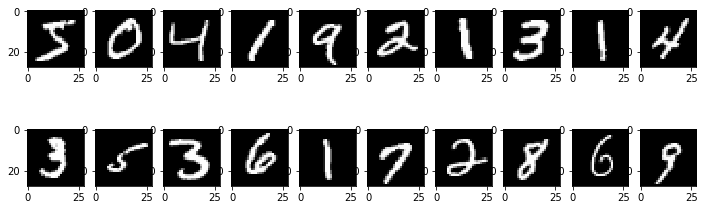

In [2]:
# Load and reshape data
(X_fmnist_train, y_fmnist_train), (X_fmnist_test, y_fmnist_test) = mnist.load_data()

X_fmnist_train = X_fmnist_train.reshape(X_fmnist_train.shape[0], 28, 28, 1)
X_fmnist_test = X_fmnist_test.reshape(X_fmnist_test.shape[0], 28, 28, 1)

n_classes_fmnist = len(np.unique(np.concatenate((y_fmnist_train, y_fmnist_test))))

y_fmnist_train_categorical = to_categorical(y_fmnist_train)
y_fmnist_test_categorical = to_categorical(y_fmnist_test)

# Plot data
plt.figure(figsize=(12, 4))
for i in range(0, 20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_fmnist_train[i,:,:,0], cmap='gray')

This IMDB movie reviews dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification.

For more information, see: https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset

In [3]:
max_num_words_in_dict = 5000

(X_imdb_train, y_imdb_train), (X_imdb_test, y_imdb_test) = imdb.load_data(num_words=max_num_words_in_dict)

## 4.2. Convolutional Neural Network

### Demo 4.2.1 Image Classification
----
The demo here shows how to construct the simplest Convolutional Neural Network model for MNIST Classification.

In [4]:
def create_convNet(num_classes):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta(), metrics=['accuracy'])
    
    return model

In [5]:
num_classes = len(np.unique(y_fmnist_train))

model = create_convNet(n_classes_fmnist)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
__________

In [6]:
model.fit(X_fmnist_train, y_fmnist_train_categorical, batch_size=256, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 9s 154us/step - loss: 3.0372 - acc: 0.6740
Epoch 2/10
60000/60000 [==============================] - 9s 152us/step - loss: 0.3598 - acc: 0.8904
Epoch 3/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.2269 - acc: 0.9282
Epoch 4/10
60000/60000 [==============================] - 9s 152us/step - loss: 0.1843 - acc: 0.9425
Epoch 5/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.1564 - acc: 0.9496
Epoch 6/10
60000/60000 [==============================] - 9s 148us/step - loss: 0.1471 - acc: 0.9537
Epoch 7/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.1389 - acc: 0.9562
Epoch 8/10
60000/60000 [==============================] - 9s 147us/step - loss: 0.1307 - acc: 0.9588
Epoch 9/10
60000/60000 [==============================] - 9s 147us/step - loss: 0.1293 - acc: 0.9591
Epoch 10/10
60000/60000 [==============================] - 9s 148us/step - loss: 0.1250 - a

0.019399999999999973

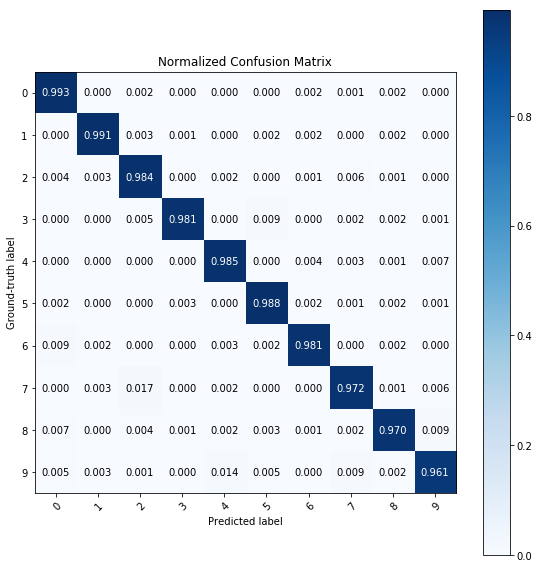

In [7]:
# Predict test data
y_fmnist_test_categorical_predict = model.predict(X_fmnist_test)
y_fmnist_test_predict = np.argmax(y_fmnist_test_categorical_predict, axis=1)

# Compute the zero-one-loss
err_loss = zero_one_loss(y_fmnist_test, y_fmnist_test_predict)
display(err_loss)

# Plot the confusion matrix
plot = PlotMetric(figsize=(8, 8))
plot.title('Confusion matrix')
plot.set_labels(['%s' % i for i in range(0,10)])
plot.confusion_matrix(y_fmnist_test, y_fmnist_test_predict)

### Demo 4.2.2 Model Observation

#### Demo 4.2.2.1 Hidden Parameters of Convolution Layer
----
The demo here shows the visualized result of the learned parameters in the first convolutional layer.

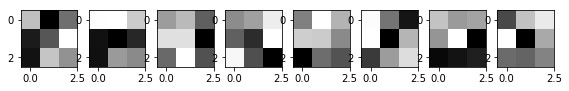

In [8]:
N_filters = model.layers[0].get_weights()[0].shape[-1]
dim_filter = model.layers[0].get_weights()[0].shape[0:2]

plt.figure(figsize=(12, 4))
for i in range(0, N_filters):
    plt.subplot(int(np.ceil(N_filters/10)), 10, i+1)
    plt.imshow(model.layers[0].get_weights()[0][:, :, 0, i], cmap='gray')
    

#### Demo 4.2.2.2 Convolution result of the 1st Convolution Layer `conv2d_1`
----
The demo here shows the convolution result of the features with the paramter learend in `conv2d_1`

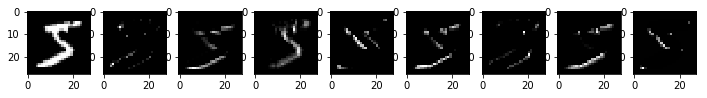

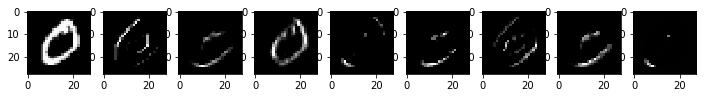

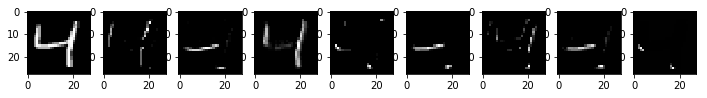

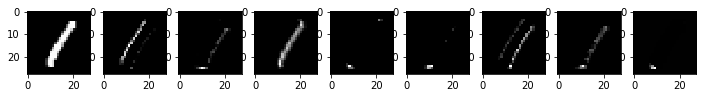

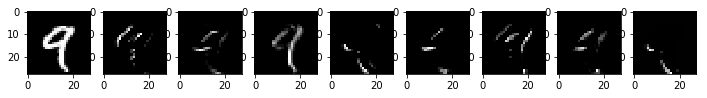

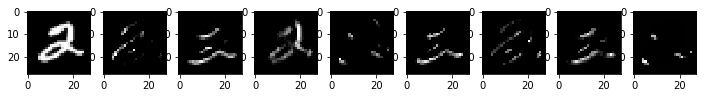

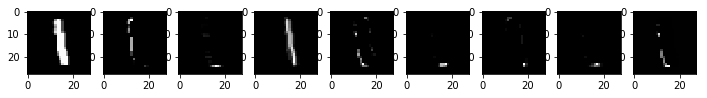

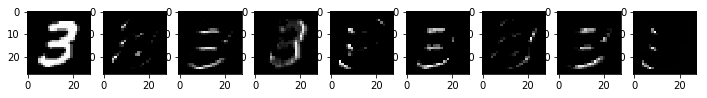

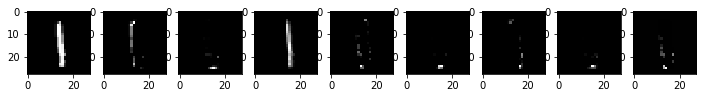

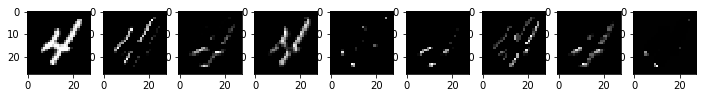

In [9]:
model_int1 = Model(inputs=model.input, outputs=model.get_layer('conv2d_1').output)

output_shape_conv1 = (28, 28)
output_channels = 8
N_show = 10

X_intermediate = model_int1.predict( X_fmnist_train[0:N_show, :, :, :] )
for i in range(0, len(X_intermediate)):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, output_channels+1, 1)
    plt.imshow(X_fmnist_train[i, :, :, 0].reshape( (28, 28) ), cmap='gray')
    
    for c in range(0, output_channels):
        xic_intermediate = X_intermediate[i,:,:,c]
        plt.subplot(1, output_channels+1, c+2)
        plt.imshow(xic_intermediate.reshape( output_shape_conv1 ), cmap='gray')


#### Demo 4.2.2.3 Convolution result of the 2nd Convolution Layer `conv2d_2`
----
The demo here shows the convolution result of the features with the paramter learend in `conv2d_2`

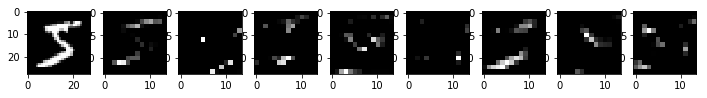

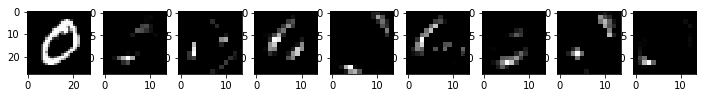

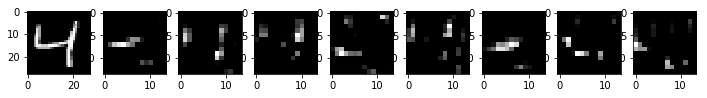

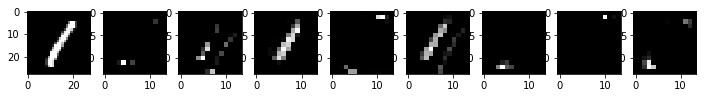

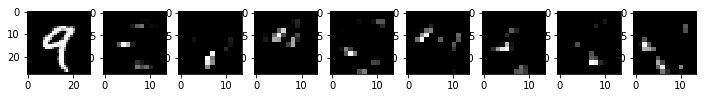

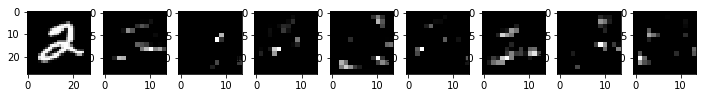

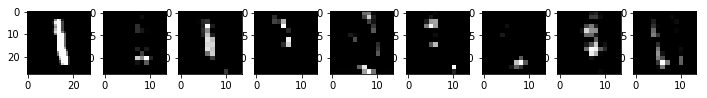

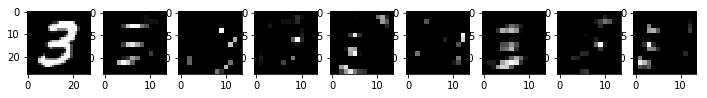

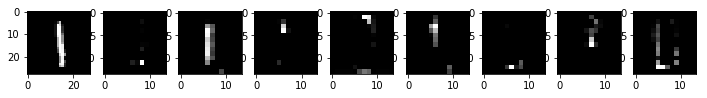

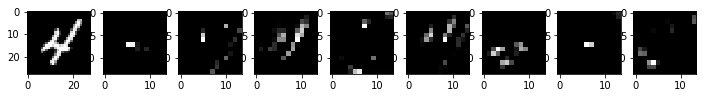

In [10]:
model_int2 = Model(inputs=model.input, outputs=model.get_layer('conv2d_2').output)

output_shape_conv1 = (14, 14)
output_channels = 8
N_show = 10

X_intermediate = model_int2.predict( X_fmnist_train[0:N_show, :, :, :] )
for i in range(0, len(X_intermediate)):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, output_channels+1, 1)
    plt.imshow(X_fmnist_train[i, :, :, 0].reshape( (28, 28) ), cmap='gray')
    
    for c in range(0, output_channels):
        xic_intermediate = X_intermediate[i,:,:,c]
        plt.subplot(1, output_channels+1, c+2)
        plt.imshow(xic_intermediate.reshape( output_shape_conv1 ), cmap='gray')


## 4.3. Applications

### Demo 4.3.1 Sentence Classification using Convolutional Neural Network

#### Demo 4.3.1.1 Text Pre-processing
----
The pre-processing here pads each sequences to the length of `max_num_words_in_sentence`

In [11]:
max_num_words_in_sentence = 400
embedding_dims = 50

X_imdb_train = sequence.pad_sequences(X_imdb_train, maxlen=max_num_words_in_sentence)
X_imdb_test = sequence.pad_sequences(X_imdb_test, maxlen=max_num_words_in_sentence)

#### Demo 4.3.1.2 Construct the Network
----
The demo here construct a neural network for training and predicting the sentences.

In [12]:
def create_NLP_convNet():
    model = Sequential()

    model.add(Embedding(max_num_words_in_dict, embedding_dims, input_length=max_num_words_in_sentence))
    model.add(Dropout(0.2))
    
    model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(250))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [13]:
model_nlp = create_NLP_convNet()
model_nlp.summary()
model_nlp.fit(X_imdb_train, y_imdb_train, batch_size=256, epochs=2, validation_data=(X_imdb_test, y_imdb_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
__________

### Demo 4.3.2 Image Classification using Pre-trained Convolutional Neural Network
----
The demo here shows how to use pre-trained convolutional neural network model to predict an image

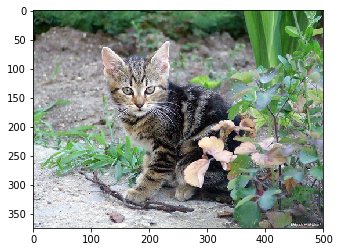

In [14]:
response = requests.get('http://farm1.static.flickr.com/55/181882736_0b23280b07.jpg')
with open(os.path.join('data', 'test.jpg'), 'wb') as f_img:
    f_img.write(response.content)
    
plt.imshow(Image.open(BytesIO(response.content)))

In [15]:
model_inceptionv3 = InceptionV3(include_top=True)

img = image.load_img(os.path.join('data', 'test.jpg'), target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = model_inceptionv3.predict(x)
label = decode_predictions(y)
display(label)

[[('n02123045', 'tabby', 0.74990463),
  ('n02123159', 'tiger_cat', 0.25006178),
  ('n02124075', 'Egyptian_cat', 3.1727286e-05),
  ('n03692522', 'loupe', 5.829917e-07),
  ('n03598930', 'jigsaw_puzzle', 1.6938897e-07)]]